# Allan Pereira Fenelon

# 1 - LEITURA DOS DADOS E IMPORTAÇÃO DE BIBLITECAS

In [85]:
import statsmodels.api as sm
from pmdarima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import timeseriesmetrics as tss
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from pmdarima import model_selection
import time
import auxiliar as ax
from sklearn.tree import DecisionTreeRegressor
from skopt.space import Real, Integer
from skopt import gp_minimize
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler

import timeseriesmetrics as mt

warnings.filterwarnings('ignore')

# DEFININDO O NOSSO PATH COM OS DADOS
DATA_PATH = '../bds/'
tickers = ['TSLA', 'NIO', 'LI', 'RIVN', 'BYDDY']

Na cédula abaixo, estamos fazendo a leitura de todos os arquivos das séries temporais. Para que o processo seja mais rápido, estanos filtrando ainda nessa etapa apenas as colunas que iremos está utilizando, que são as colunas de __Date__ e __Close__ que são respectivamente a data e o valor de fechamento das ações.

In [86]:
times_series = {}
for name in tickers:
    serie = pd.read_csv(DATA_PATH + name + '.csv' ,sep=',',usecols=[0,4])
    times_series[name] = serie

# 2 - DESCRIÇÃO DAS SÉRIES TEMPORAIS

As séries temporais que serão estudadas nesse arquivos são sobre o valor de fechamento sobre os preços de ações de algumas empresas no setor de predução de carros elétricos, realizaremos alguns estudos e testes de modelos.

Um dos objetivos é identificar modelos para a modelagem de séries temporais financeiras, entender o comportamento delas e fazer previões baseadas nos modelos que criamos.



$\textbf{1. Tesla, Inc. (TSLA)} \\$
A Tesla é uma das líderes globais na produção de veículos elétricos e soluções de armazenamento de energia. Fundada por Elon Musk, a empresa é conhecida por seus carros elétricos de alto desempenho, como o Model S, Model 3, Model X e Model Y. Além de veículos elétricos, a Tesla também produz baterias e sistemas de energia solar.

$\textbf{2. BYD Company Limited (BYDDY)} \\$
A BYD é uma das maiores fabricantes de veículos elétricos e baterias do mundo. Com sede na China, a empresa produz uma ampla gama de veículos elétricos, incluindo ônibus e carros de passageiros, além de baterias e tecnologias de energia renovável. A BYD tem um forte foco em soluções sustentáveis e é uma das líderes no mercado de veículos elétricos na China. 

$\textbf{3. Li Auto Inc. (LI)} \\$
Li Auto é uma fabricante chinesa de veículos elétricos e híbridos plug-in. A empresa é conhecida por seus SUVs híbridos, como o Li ONE. Li Auto se concentra em fornecer veículos elétricos com tecnologias avançadas e uma extensa rede de recarga e suporte. 

$\textbf{4. NIO Inc. (NIO)} \\$
A NIO é uma fabricante de veículos elétricos premium com sede na China. A empresa é conhecida por seus SUVs elétricos e sedans, como o ES8, ES6 e o EC6. A NIO também se destaca por seu modelo de substituição de bateria, oferecendo um serviço onde os clientes podem trocar as baterias de seus veículos em estações de troca rápida. 

$\textbf{5. Rivian Automotive Inc. (RIVN)} \\$
A Rivian é uma fabricante americana de veículos elétricos focada em modelos voltados para aventuras e transporte sustentável. Fundada em 2009 e com sede na Califórnia, a empresa desenvolve caminhonetes e SUVs, como os modelos R1T e R1S, projetados para oferecer experiências conectadas e melhorar ao longo do tempo por meio de atualizações de software. A Rivian também fabrica vans elétricas para frotas, como as usadas pela Amazon.


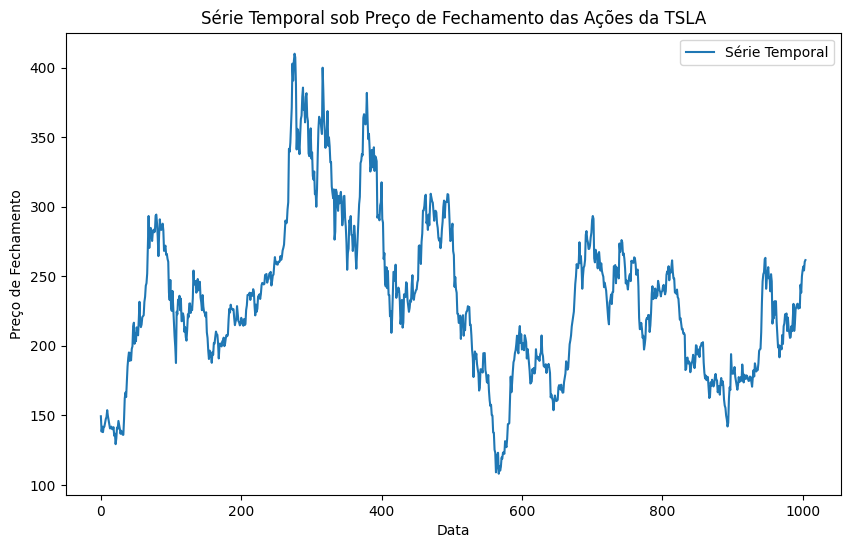

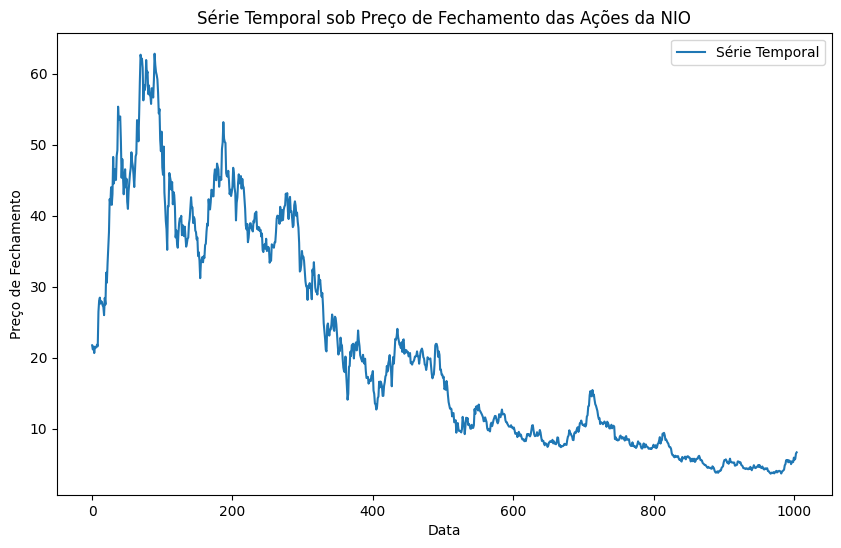

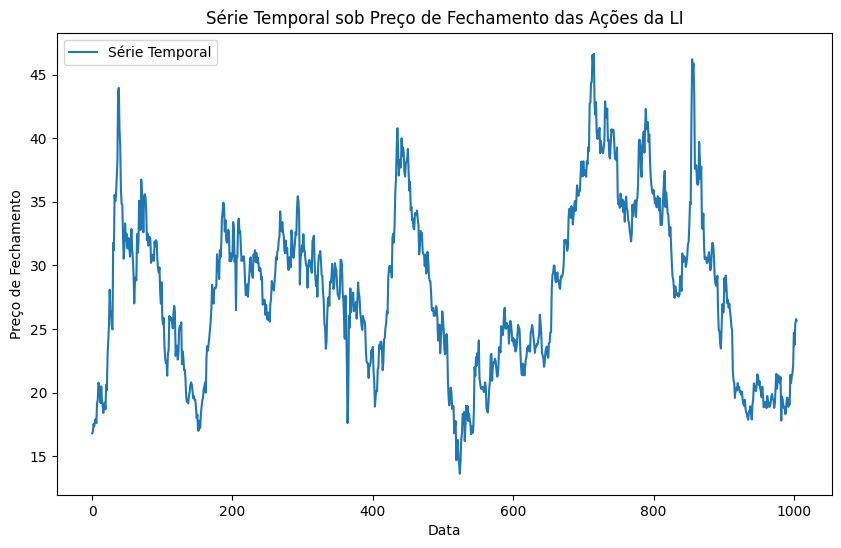

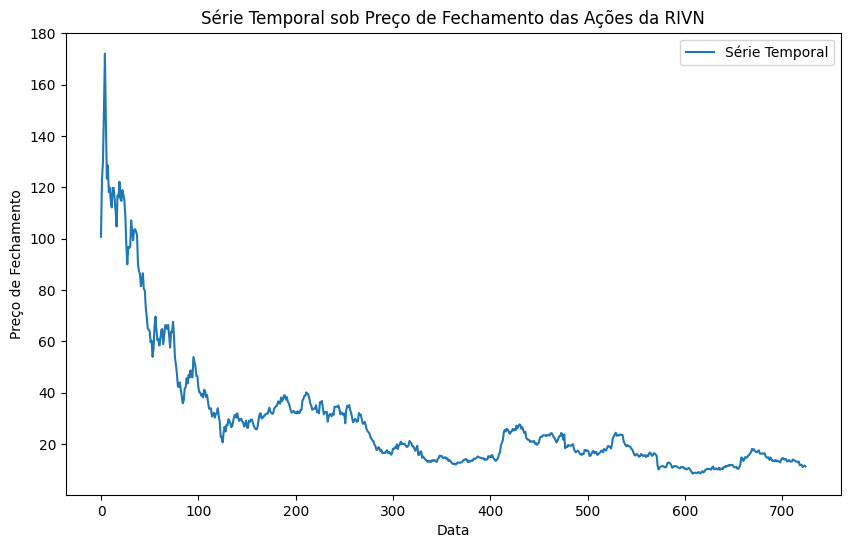

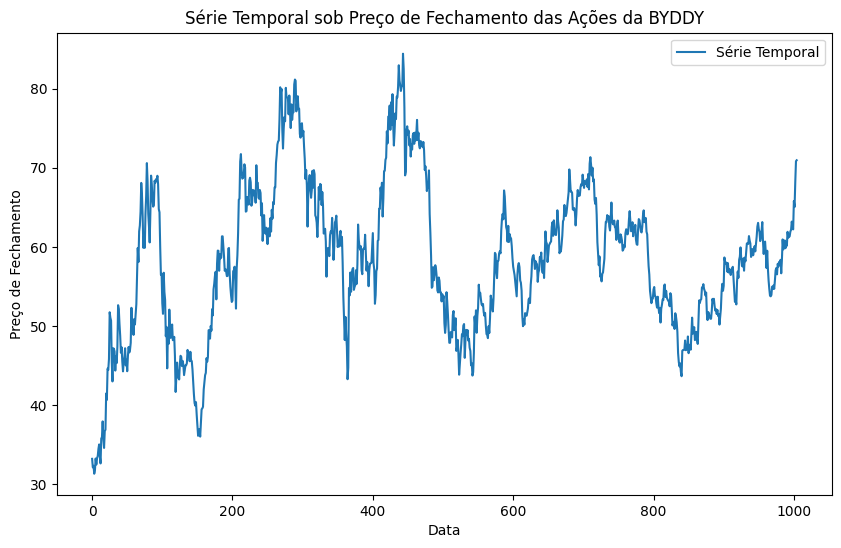

In [87]:
for name in tickers:
    plt.figure(figsize=(10, 6))
    plt.plot(times_series[name].index,times_series[name]['Close'], label='Série Temporal')
    plt.title(f'Série Temporal sob Preço de Fechamento das Ações da {name}')
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento')
    plt.legend()
    plt.show()

# 3 - PRÉ-PROCESSAMENTO

Nesta etapa, vamos se dedicar ao estudo de Lags relevantes, que estão associado ao teste de associação. Queremos fazer estudo em períodos diferentes do tempo para achar uma associação entre esse período do tempo na influencia nos demais.

Usaremos a autocorrelação parcial para fazer o estudo de Lags significativos nas nossas séries temporais. A Autocorrelação Parcial (PACF) mede a correlação entre uma variável(ou período de tempo neste caso) e suas defasagens, removendo o efeito das defasagens intermediárias.



$$
R_k = \frac{1}{N} \sum_{t=1}^{N-k} (X_t - \mu)(X_{t+k} - \mu)
$$

Onde:
\begin{align*}
R_k & : \text{ autocorrelação no lag } k \\
N & : \text{ número total de observações na série} \\
X_t & : \text{ valor da série no tempo } t \\
X_{t+k} & : \text{ valor da série no tempo } t+k \\
\mu & : \text{ média da série}
\end{align*}

Para obter os lags significantes aplicamos um teste de hipótese, onde :

$$
(H_0): \text{O lag é significante} \\

(H_a): \text{O lag não é significante}
$$

Vamos aceitar ($H_0$) quando nossa autocorrelação parcial estiver fora do nosso intervalo de confiança então vamos ter que o nosso lag no instante i é significante, caso contrário, aceitamos ($H_a$).

significantLags: [1, 5, 8, 10, 19, 25]
          Date       Close   (Close-1)   (Close-5)   (Close-8)  (Close-10)  \
25  2020-11-05  146.029999  140.326660  136.943329  140.093338  141.929993   
26  2020-11-06  143.316666  146.029999  129.346664  141.559998  140.210007   

    (Close-19)  (Close-25)  
25  144.666672  149.386673  
26  147.433334  138.363327  
significantLags: [1, 2, 3, 4, 5, 6, 8, 13, 19, 21, 22, 26]
          Date      Close  (Close-1)  (Close-2)  (Close-3)  (Close-4)  \
26  2020-11-06  41.630001  42.349998  37.709999  35.500000      33.32   
27  2020-11-09  44.020000  41.630001  42.349998  37.709999      35.50   

    (Close-5)  (Close-6)  (Close-8)  (Close-13)  (Close-19)  (Close-21)  \
26      30.58      31.99  28.440001   27.959999   21.850000   21.440001   
27      33.32      30.58  27.510000   27.860001   21.620001   21.469999   

    (Close-22)  (Close-26)  
26   21.559999       21.76  
27   21.440001       21.18  
significantLags: [1, 5]
         Date  Close  (

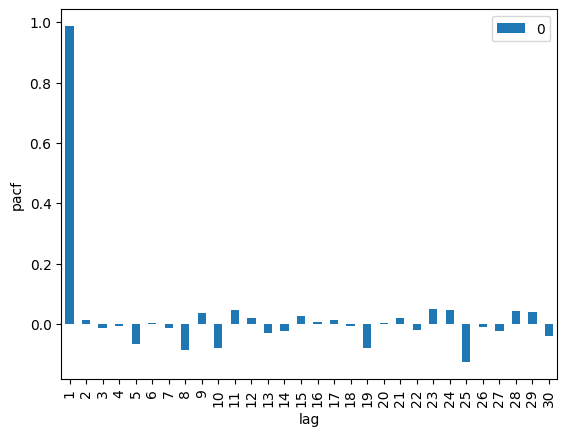

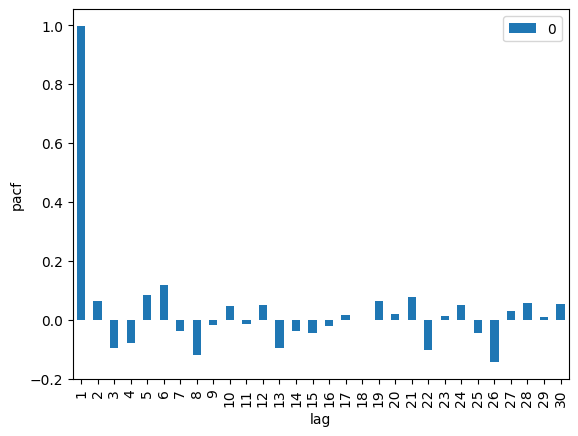

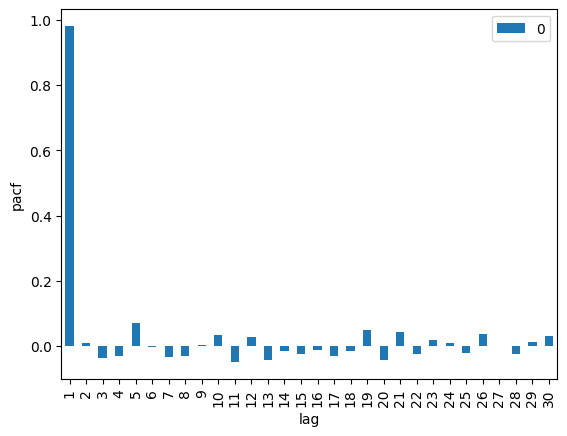

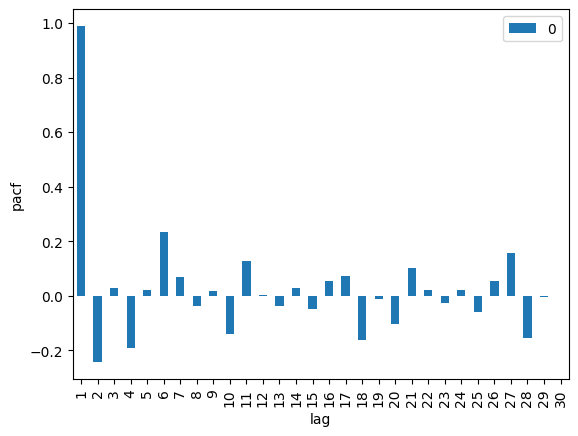

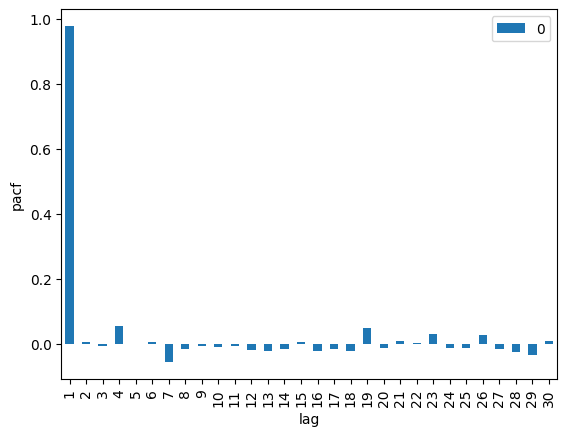

In [88]:
n_lags_significantes = {
    'TSLA': 30, 'NIO': 30, 'LI': 30, 'RIVN': 30, 'BYDDY': 30
}
for name in tickers:
    lags = ax.getSignificantLags(y=times_series[name]['Close'], nLags =n_lags_significantes[name], alpha=0.05)
    times_series[name] = ax.appendLagVariables(yNm='Close', significantLags = lags, df = times_series[name], dropna=True)


Na cédula abaixo, estamos inicialmente, para cada série temporal que tem o nome em tickers, pegando nossas features __X__ e o target __y__ de cada uma, após estamos dividindo a série em treino (80%) e teste (20%). 

In [220]:
X = {}
y = {}
for name in tickers:
    times_series[name] = times_series[name].dropna()
    X[name] = times_series[name].drop('Close', axis=1)
    X[name] = X[name].drop('Date', axis=1)
    y[name] = times_series[name]['Close']
    
X_train = {}
X_test = {}
y_train = {}
y_test = {}

for name in tickers:
    X_train[name], X_test[name], y_train[name], y_test[name] = train_test_split(X[name], y[name], 
                                                                                test_size=0.2, shuffle=False)

Obteremos agora a previsão via random walk a qual utilizaremos como modelo base, modelaremos o seu erro nos modelos que veremos na seção de processamento.

Mas o que é Random Walk?

Um random walk nada mais é que um processo estocástico onde o valor no instante t é igual ao valor no instante t-1 mais um erro aleatório. Matemátciamente temos:

$$
X_t = X_{t-1} + \epsilon_t \\
$$

Onde:

$$
X_t: \text{é o valor da série no instante t}\\
X_{t-1}: \text{é o valor da série no instante t-1}\\
\epsilon_t: \text{é o erro (ruído branco) no instante t}
$$



In [234]:
# PREVISÕES VIA RANDOM WALK E AJUSTE DA MATRIZ X DE FEATURES
X_rw = {}
y_rw = {}
for name in tickers:
    X_rw[name] = X[name].shift(1)
    X_rw[name].iloc[0] = X[name].iloc[0]

    y_rw[name] = y[name].shift(1)
    y_rw[name].iloc[0] = y[name].iloc[0]

Obteremos o erro via previsão do modelo base (Random Walk), e dividiremos em treino e teste

In [235]:
X_rw_e = {}
y_rw_e = {}
for name in tickers:
    X_rw_e[name] = X[name] - X_rw[name]

    y_rw_e[name] = y[name] - y_rw[name]


In [236]:
X_train_e = {}
X_test_e = {}
y_train_e = {}
y_test_e = {}

for name in tickers:
    X_train_e[name], X_test_e[name], y_train_e[name],y_test_e[name] = train_test_split(X_rw_e[name], y_rw_e[name], 
                                                                                test_size=0.2, shuffle=False)

# 4 - PROCESSAMENTO

Nesta seção abordaremos a modelagem de cada uma das séries temporais. Abordaremos modelos que foram visto em sala de aula da diciplina de __Séries Temporais__ e __Estatística Computacional__.

Esse projeto terá em vista a modelagem nos erros de um modelo __base line__, a qual será pelo modelo __Random Walk__.

Logo, modelaremos $E$, onde $E = y_{true} - \hat{y}$, onde $\hat{y}$ é a previsão via modelo __Random Walk__. Na seção de pré-processamento já foi feito o deslocamento vertical em uma posição das observações das séries originais, diante disso, podemos, para cada série temporal encontrar o erro da previsão do Random Walk a qual modelaremos.

Quando for modelado o erro do ramdom walk faremos a previsão onde gerará $\hat{E}$ que é a previsão do random walk, onde iremos agregar nas previsão total $\hat{y} = \hat{E} + \hat{y}_{rw}$

Modelaremos também as séries temporais, e compararemos em seções futuras com a modelagem do wandom walk.

Na cédula abaixo, calculamos o erro via previsão Random Walk, a qual será modelada.

In [225]:
E_rw = {}

for name in tickers:
    E_rw[name] = y_train[name] - y_train_rw[name]

## 4.1 - MODELAGEM

### 4.1.1 Regressão Linear

A regressão linear tem como objetivo geral modelar a relação da variável dependente $y$ entre uma e várias outras variáveis independentes $X =[x_1,x_2,...,x_n]$. O modelo de regressão linear simples pode ser expresso, matricialmente como:
$$y = X^T\beta+\epsilon$$

Onde:

$
y: \text{É a variável dependnete} \\
X^T: \text{É o vetor de variáveis independentes transposta}\\
\beta: \text{É o vetor de parâmetros}\\
\epsilon: \text{É o vetor de erros} \\
$

É necessário, por definição que $\epsilon \sim \mathcal{N}(0, \sigma^2)$, ou seja $\epsilon$ tem uma distribuição normaç com média zero e variância $\sigma^2$.

O nosso objetivo, é achar estimativas razoáveis para $\beta$ através do $\hat{\bm{\beta}}$ que será dada pela estimativa dos mínimos quadrados. Ou seja, queremos estimar o vetor $\beta$  que minimiza a soma dos erros ao quadrado. Em otras palavras queremos minimizar:

$$
S = \sum_{i=1}^n e_i^2 = \|Y - X^T \beta\|^2_2 = (Y - X^T \beta)^2
$$

onde, $e_i = y_i - \hat{y}_{i-1}$ e $\hat{y}_i = X_i^T \beta$

Para isso, basta derivar em relação à $\beta$ e iguala a zero, a qual teremos a equação:

$$
\frac{\partial S}{\partial \beta} = -2X(Y - X^T \beta) = 0
$$

A qual obtemos: $X^T X \hat{\beta} = X^T Y$. Portanto:

$$
\hat{\beta} = (X^TX)^{-1}X^TY
$$

Utilizaremos a biblioteca __scikit-learn__ onde há implementado todas as noções vistas anteriormente.

#### 4.1.1.1 MODELAGEM E PREVISÃO DO ERRO DO RANDOM WALK

Faremos a instância de cada modelo de Regressão Linear e chamar o método fit para que o modelo seja treinado, em cada iteração é guardado o tempo de execução para uma comparação de desempenho em seções futuras.

In [226]:
model_rw_LR = {}
tempos_train_rw_LR = {}
for name in tickers:
    start_time = time.time()
    model_rw_LR[name] = LinearRegression(positive=True)
    model_rw_LR[name].fit(X_train_rw[name], E_rw[name])
    end_time = time.time()
    tempos_train_rw_LR[name] = end_time - start_time

Nesse etapa faremos a previsão para o erro do random walk

In [227]:
tempos_predict_rw_LR = {}
previsoes_erros_rw_LR = {}
previsoes_rw_LR = {}
for name in tickers:
    start_time = time.time()
    previsoes_erros_rw_LR[name] = model_rw_LR[name].predict(X_test_rw[name])
    end_time = time.time()
    tempos_predict_rw_LR[name] = end_time - start_time
    previsoes_rw_LR[name] = y_test_rw[name] + previsoes_erros_rw_LR[name]

Depois das previsões, plotaremos as previsões via modelagem dos erros do Random Walk. A análise de desempenho ficará na seção respectiva para isso.

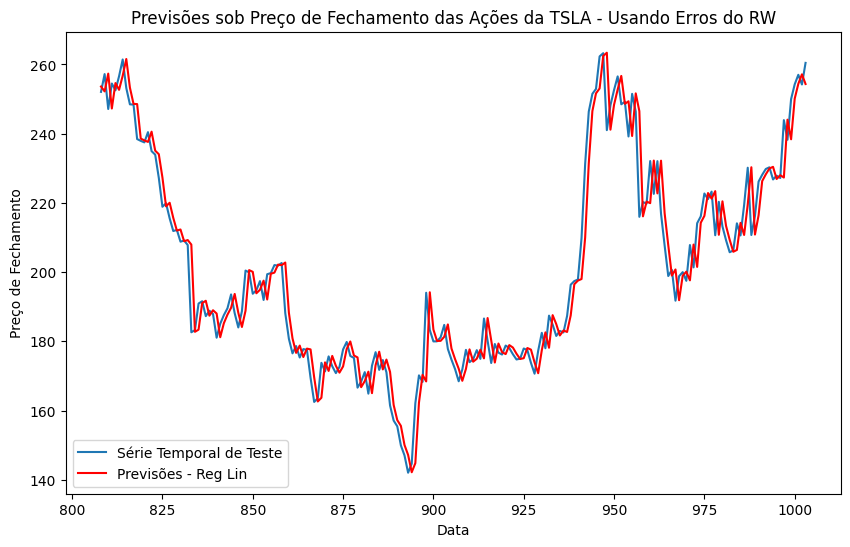

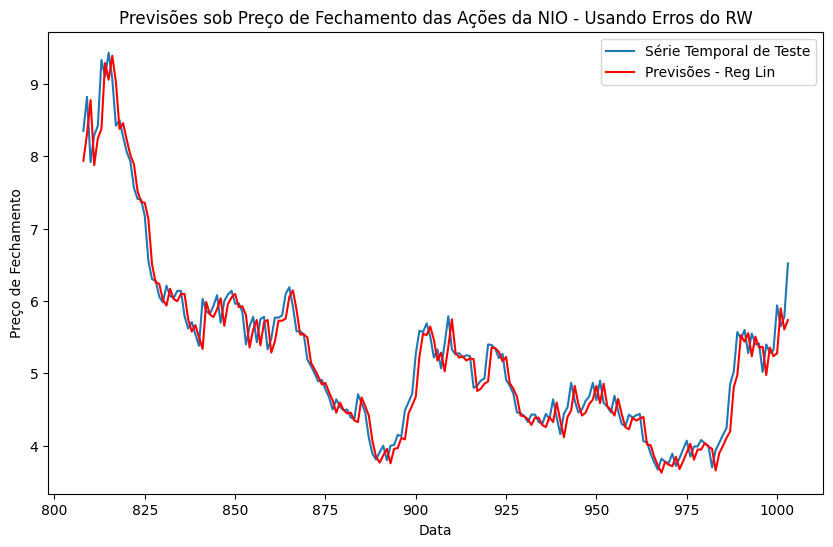

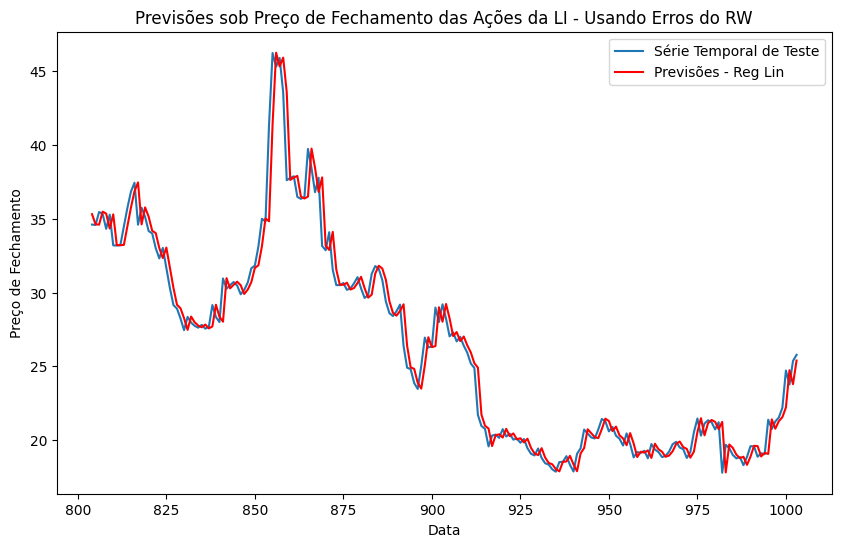

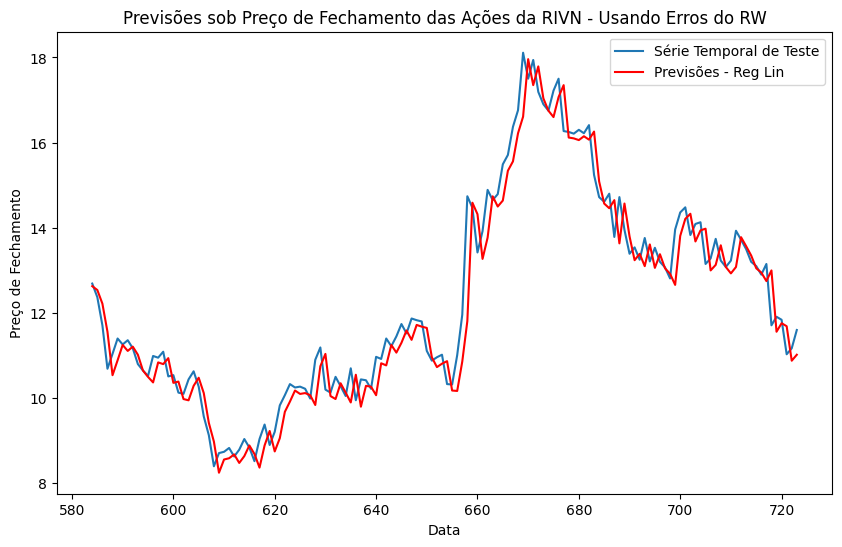

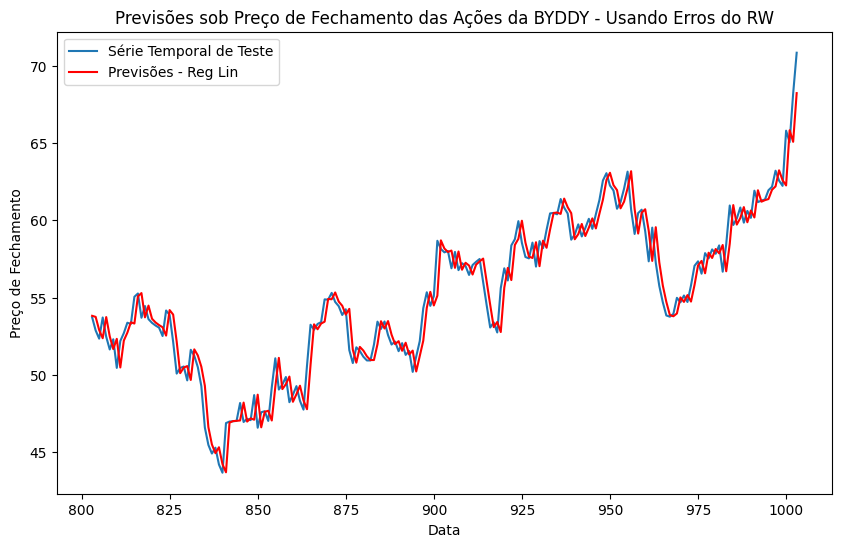

In [228]:
for name in tickers:
    plt.figure(figsize=(10, 6))
    plt.plot(X_test[name].index, y_test[name], label='Série Temporal de Teste')
    plt.plot(X_test[name].index, previsoes_rw_LR[name], label='Previsões - Reg Lin', color='red')
    plt.title(f'Previsões sob Preço de Fechamento das Ações da {name} - Usando Erros do RW')
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento')
    plt.legend()
    plt.show()

#### 4.1.1.2 MODELAGEM E PREVISÃO DA SÉRIE TEMPORAL ORIGINAL

Faremos a instância de cada modelo de Regressão Linear e chamar o método fit para que o modelo seja treinado, em cada iteração é guardado o tempo de execução para uma comparação de desempenho em seções futuras.

In [229]:
model_ts_LR = {}
tempos_train_ts_LR = {}
for name in tickers:
    start_time = time.time()
    model_ts_LR[name] = LinearRegression(positive=True)
    model_ts_LR[name].fit(X_train_rw[name], y_train[name])
    end_time = time.time()
    tempos_train_ts_LR[name] = end_time - start_time

Fazendo a previsão e plotagem nos códigos seguintes

In [230]:
tempos_predict_ts_LR = {}
previsoes_ts_LR = {}
for name in tickers:
    start_time = time.time()
    previsoes_ts_LR[name] = model_ts_LR[name].predict(X_test_rw[name])
    end_time = time.time()
    tempos_predict_ts_LR[name] = end_time - start_time

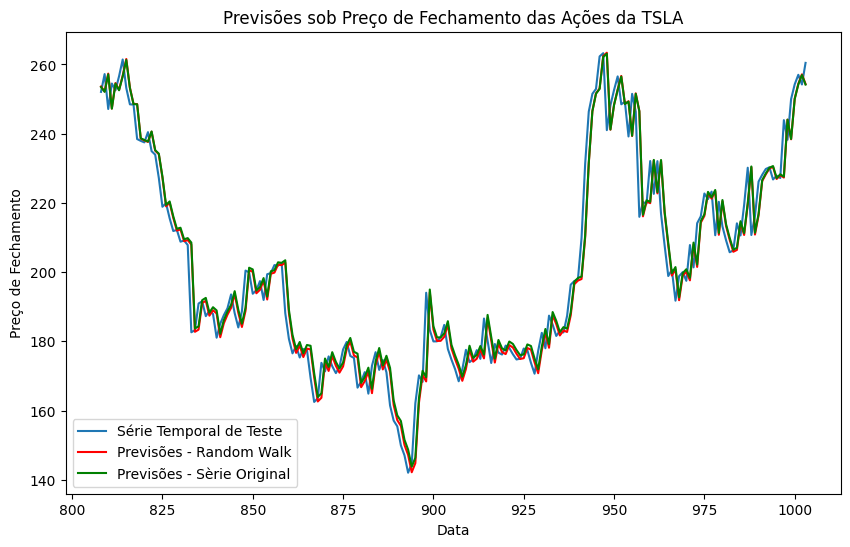

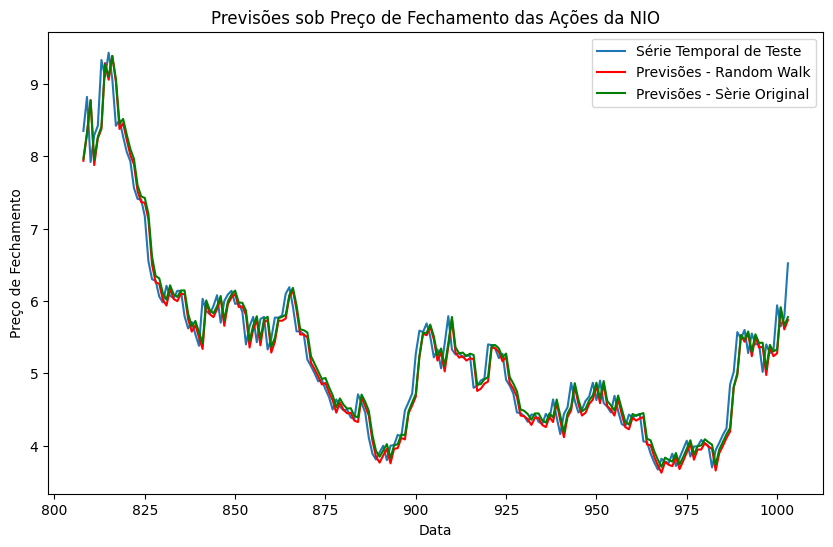

KeyboardInterrupt: 

In [231]:
for name in tickers:
    plt.figure(figsize=(10, 6))
    plt.plot(X_test[name].index, y_test[name], label='Série Temporal de Teste')
    plt.plot(X_test[name].index, previsoes_rw_LR[name], label='Previsões - Random Walk', color='red')
    plt.plot(X_test[name].index, previsoes_ts_LR[name], label='Previsões - Sèrie Original', color='green')
    plt.title(f'Previsões sob Preço de Fechamento das Ações da {name}')
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento')
    plt.legend()
    plt.show()

#### 4.1.1.3 DESEMPENHOS PRELIMINARES

In [ ]:
import auxiliar as ax

In [ ]:
metricas_rw_LR = {}
for name in tickers:
    metricas_rw_LR[name] = ax.calcular_metricas_regressao(y_test[name], previsoes_rw_LR[name])

In [ ]:
metricas_ts_LR = {}
for name in tickers:
    metricas_ts_LR[name] = ax.calcular_metricas_regressao(y_test[name], previsoes_ts_LR[name])

In [ ]:
def get_table_metrics(tickers: dict, rw: bool, metricas: dict, tempo_fit: dict, tempo_predict: dict):
    metricas_table = {
        'TS': [ticker for ticker in tickers],
        'rw': rw,
        'MSE': [metricas[ticker][metricas[ticker]['Métrica'] == 'MSE']['Valor'].values[0] for ticker in tickers],
        'MAE': [metricas[ticker][metricas[ticker]['Métrica'] == 'MAE']['Valor'].values[0] for ticker in tickers],
        'MAPE': [metricas[ticker][metricas[ticker]['Métrica'] == 'MAPE']['Valor'].values[0] for ticker in tickers],
        'RMSE': [metricas[ticker][metricas[ticker]['Métrica'] == 'RMSE']['Valor'].values[0] for ticker in tickers],
        'R^2': [metricas[ticker][metricas[ticker]['Métrica'] == 'R^2']['Valor'].values[0] for ticker in tickers],
        'U de THEIL': [metricas[ticker][metricas[ticker]['Métrica'] == 'THEIL']['Valor'].values[0] for ticker in tickers],
        'ARV': [metricas[ticker][metricas[ticker]['Métrica'] == 'ARV']['Valor'].values[0] for ticker in tickers],
        'WPOCID': [metricas[ticker][metricas[ticker]['Métrica'] == 'WPOCID']['Valor'].values[0] for ticker in tickers],
        'Tempo Fit (s)': [tempo_fit[ticker] for ticker in tickers],
        'Tempo Predict (s)': [tempo_predict[ticker] for ticker in tickers]
    }
    return metricas_table

__OBSERVAÇÔES:__ Na tabela RW é uma variável booleana, onde identificamos as previsões e resultados da modelagem do erro do random walk(quando RR = True) enquando que para RW = False são resultados referentes a modelagem da série temporal original.

A tabela fornecida apresenta um resumo das métricas de desempenho de modelos de séries temporais para diferentes tickers de ações, com dois cenários: um utilizando a modelagem do erros do Random Walk (rw = True) e outro com a modelagem da série temporal original (rw = False). As colunas mostram valores de várias métricas de avaliação, como MSE (Erro Quadrático Médio), MAE (Erro Absoluto Médio), MAPE (Erro Percentual Absoluto Médio), RMSE (Raiz do Erro Quadrático Médio), R² (Coeficiente de Determinação), entre outras. Para cada ticker, são apresentados também os tempos de treinamento (fit) e previsão (predict) em segundos. Por exemplo, para o ticker BYDDY, a modelagem dos erros do Random Walk apresentou um MSE de 1.433562 e um R² de 0.943405, enquanto no modelo da série temporal original, o MSE foi ligeiramente maior, 1.438285, mas com um R² quase igual. A tabela permite comparar o impacto da utilização da estratégia da modelagem dos erros do Random Walk no desempenho e na eficiência do modelo, além de mostrar os tempos computacionais envolvidos.

Ao analisar os resultados da tabela, é possível observar que a modelagem do erro do Random Walk (rw = True) não resultou em melhorias significativas em comparação com a modelagem da Série Temporal Original (rw = False). Em muitos casos, as métricas como MSE, MAE e RMSE apresentaram resultados muito próximos ou ligeiramente inferiores com a modelagem dos erros do Random Walk, mas sem grandes melhorias no desempenho do modelo. Por exemplo, no caso de BYDDY, o MSE foi de 1.433562 coma modelagem dos erros do Random Walk e 1.438285 sem ele, uma diferença pequena, indicando que o modelo com erro de Random Walk não trouxe uma melhoria substancial.

In [ ]:

metricas_table_rw_LR = pd.DataFrame(get_table_metrics(tickers, True, metricas_rw_LR, tempos_train_rw_LR, tempos_predict_rw_LR))
metricas_table_ts_LR = pd.DataFrame(get_table_metrics(tickers, False, metricas_ts_LR, tempos_train_ts_LR, tempos_predict_ts_LR))


metricas_table_LR = pd.concat([metricas_table_rw_LR, metricas_table_ts_LR], axis=0, ignore_index=True)
metricas_table_LR = metricas_table_LR.sort_values(by=['TS']).reset_index(drop=True)
metricas_table_LR


,TS,rw,MSE,MAE,MAPE,RMSE,R^2,U de THEIL,ARV,WPOCID,Tempo Fit (s),Tempo Predict (s)
0,BYDDY,True,1.433562,0.938355,0.017076,1.197314,0.943405,0.997130,0.056595,0.570000,0.003003,0.001022
1,BYDDY,False,1.438285,0.945937,0.017249,1.199285,0.943218,0.999648,0.056782,0.570000,0.003994,0.000995
2,LI,True,1.561494,0.808159,0.029816,1.249597,0.965849,1.001469,0.034151,0.507538,0.004000,0.001987
3,LI,False,1.560841,0.819231,0.030517,1.249336,0.965863,1.001053,0.034137,0.512563,0.002983,0.000991
4,NIO,True,0.063306,0.187041,0.034878,0.251607,0.955763,1.014226,0.044237,0.471795,0.006005,0.003006
5,NIO,False,0.062408,0.188183,0.035212,0.249815,0.956391,1.000962,0.043609,0.471795,0.006558,0.002013
6,RIVN,True,0.319543,0.417125,0.033920,0.565281,0.944412,1.067417,0.055588,0.561151,0.002998,0.000996
7,RIVN,False,0.332423,0.432168,0.035839,0.576561,0.942172,1.106118,0.057828,0.561151,0.004014,0.000994
8,TSLA,True,53.248910,5.310760,0.026319,7.297185,0.939901,1.000228,0.060099,0.543590,0.003996,0.002008
9,TSLA,False,53.278514,5.347797,0.026611,7.299213,0.939868,1.000666,0.060132,0.543590,0.006002,0.001984


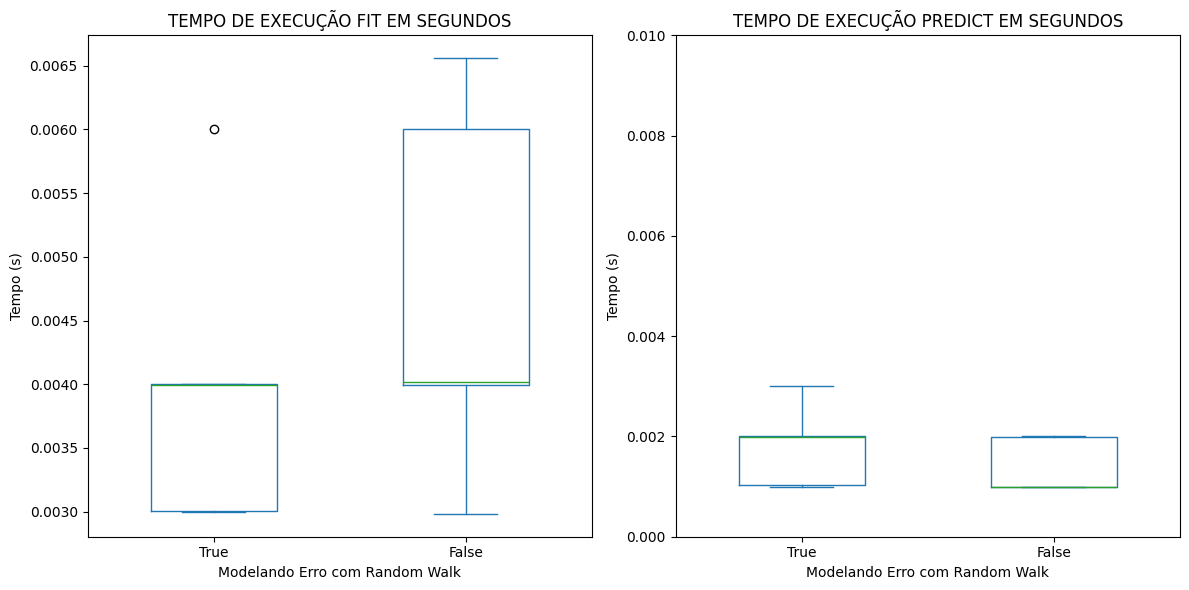

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))


metricas_table_LR[metricas_table_LR['rw'] == True]['Tempo Fit (s)'].plot.box(ax=ax[0], positions=[0], widths=0.5)
metricas_table_LR[metricas_table_LR['rw'] == False]['Tempo Fit (s)'].plot.box(ax=ax[0], positions=[1], widths=0.5)
ax[0].set_title("TEMPO DE EXECUÇÃO FIT EM SEGUNDOS")
ax[0].set_ylabel("Tempo (s)")
ax[0].set_xlabel("Modelando Erro com Random Walk")
ax[0].set_xticklabels(['True', 'False'])


metricas_table_LR[metricas_table_LR['rw'] == True]['Tempo Predict (s)'].plot.box(ax=ax[1], positions=[0], widths=0.5)
metricas_table_LR[metricas_table_LR['rw'] == False]['Tempo Predict (s)'].plot.box(ax=ax[1], positions=[1], widths=0.5)
ax[1].set_title("TEMPO DE EXECUÇÃO PREDICT EM SEGUNDOS")
ax[1].set_ylabel("Tempo (s)")
ax[1].set_ylim(0, 0.01) 
ax[1].set_xlabel("Modelando Erro com Random Walk")
ax[1].set_xticklabels(['True', 'False'])

plt.tight_layout()
plt.suptitle("")
plt.show()

### 4.1.2 Modelo Arima

#### 4.1.2.1 MODELAGEM E PREVISÃO DO ERRO DO RANDOM WALK

In [ ]:
import pmdarima as pm

Utilizaremos o AutoARIMA para identificar os melhores parâmetros __p,d,q__ do modelo ARIMA para cada série temporal. Durante essa etapa, o modelo ideal é ajustado (fit), e o tempo de execução para esse processo está sendo monitorado.

In [ ]:
models_rw_ARIMA = {}
tempos_train_rw_ARIMA= {}

for name in tickers:
    start_time = time.time()
    X_data = np.array(X_train_rw[name].index).reshape(-1, 1)
    y_data = np.array(E_rw[name]).reshape(-1, 1)
    # Ajustando o modelo AutoARIMA
    models_rw_ARIMA[name] = pm.auto_arima(X=X_data, y=y_data, seasonal=False, m=1, stepwise=True, trace=True)
    end_time = time.time()
    tempos_train_rw_ARIMA[name] = end_time - start_time

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=5735.155, Time=1.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5728.353, Time=0.66 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5729.791, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5729.811, Time=0.65 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5731.205, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5729.838, Time=0.19 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 3.090 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2663.499, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2654.170, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2653.315, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2653.529, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2654.393, Time=0.33 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2655.295, Time=0.31 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=266

Nos códigos seguintes realizamos as previsões para cada série temporal do erro do ramdom walk, e onde no final agregramos o erro previsto mais a previsão via random walk a qual fica:

$$
\hat{y} = \hat{y}_{rw} + \hat{E}_{pred,rw}
$$

In [ ]:
previsoes_erros_rw_ARIMA = {}
previsoes_rw_ARIMA = {}
tempos_predict_rw_ARIMA = {}
for name in tickers:
    start_time = time.time()
    X_test_exog = np.array(X_test_rw[name].index).reshape(-1, 1)
    previsoes_erros_rw_ARIMA[name] = models_rw_ARIMA[name].predict(len(X_test_rw[name]), X= X_test_exog)
    previsoes_rw_ARIMA[name] = y_test_rw[name] + previsoes_erros_rw_ARIMA[name]
    end_time = time.time()
    tempos_predict_rw_ARIMA[name] = end_time - start_time

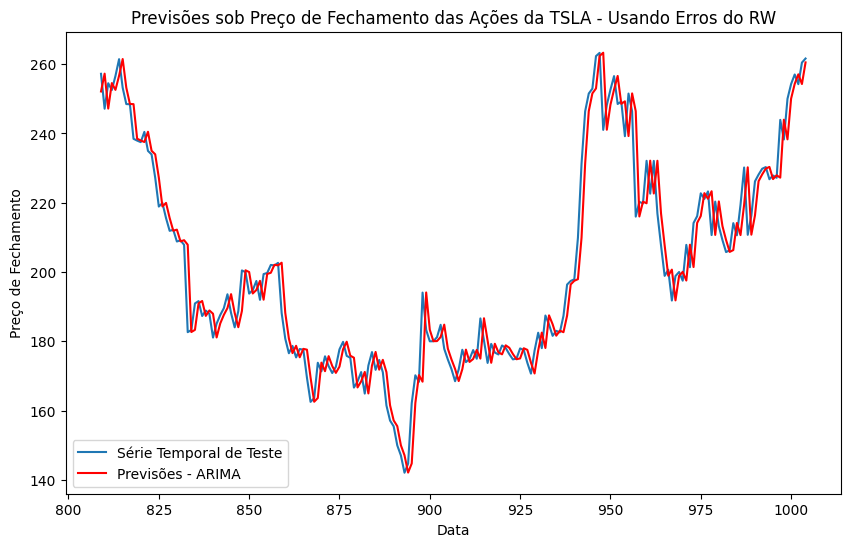

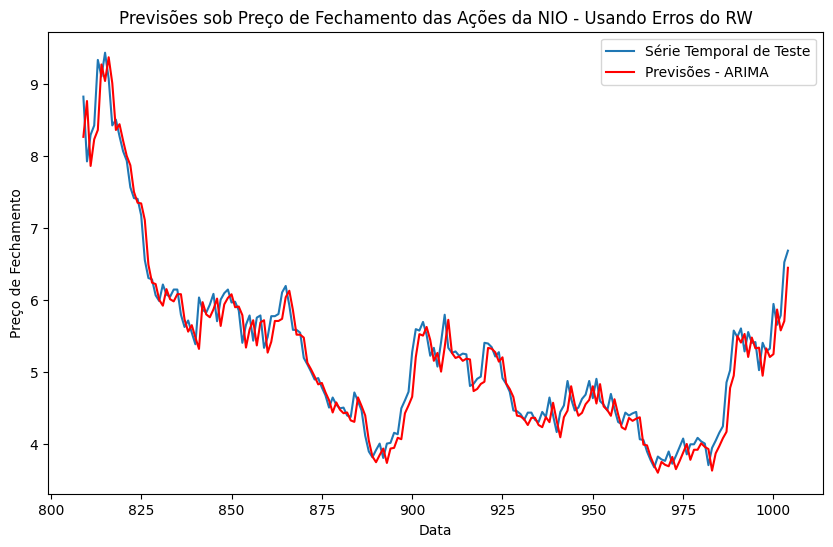

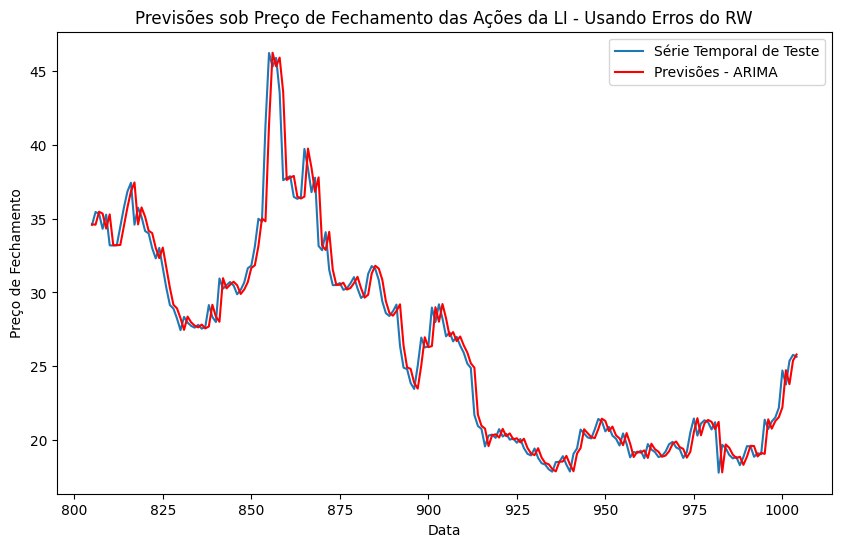

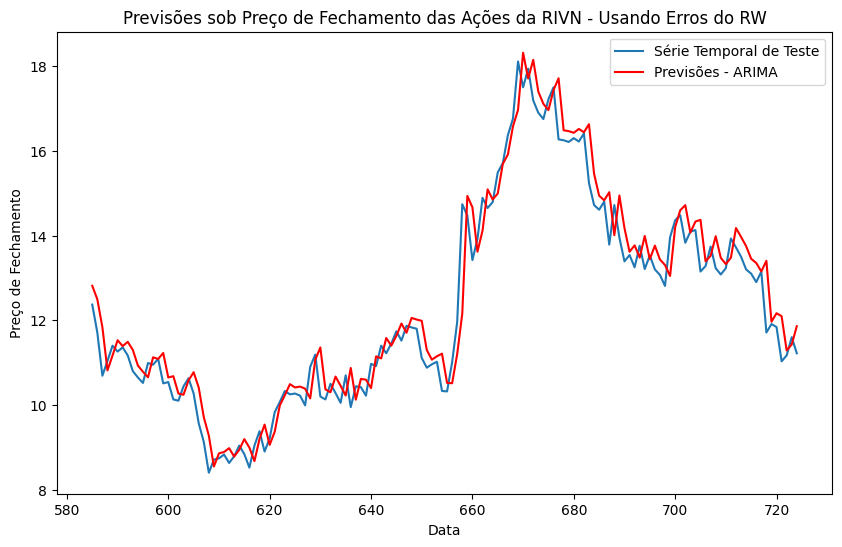

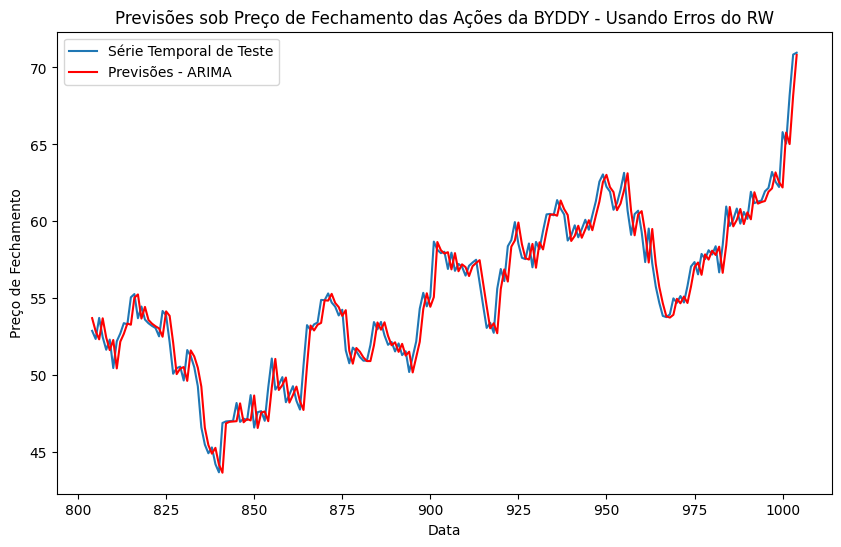

In [ ]:
for name in tickers:
    plt.figure(figsize=(10, 6))
    plt.plot(X_test[name].index, y_test[name], label='Série Temporal de Teste')
    plt.plot(X_test[name].index, previsoes_rw_ARIMA[name], label='Previsões - ARIMA', color='red')
    plt.title(f'Previsões sob Preço de Fechamento das Ações da {name} - Usando Erros do RW')
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento')
    plt.legend()
    plt.show()

#### 4.1.2.2 MODELAGEM E PREVISÃO DA SÉRIE TEMPORAL ORIGINAL

Neste momento modelaremos a nossa série temporal original. Inicialmente obtemos os melhores mdoelos para cada série temporal e em seguida realizamos as previsões repesctivas.

In [ ]:
models_ts_ARIMA = {}
tempos_train_ts_ARIMA= {}

for name in tickers:
    start_time = time.time()
    X_data = np.array(X_train[name].index).reshape(-1, 1)
    y_data = np.array(y_train[name]).reshape(-1, 1)
    # Ajustando o modelo AutoARIMA
    models_ts_ARIMA[name] = pm.auto_arima(X=X_data, y=y_data, seasonal=False, m=1, stepwise=True, trace=True)
    end_time = time.time()
    tempos_train_ts_ARIMA[name] = end_time - start_time

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=5741.104, Time=1.45 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9932.345, Time=0.35 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8926.598, Time=1.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5739.029, Time=1.23 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=8132.665, Time=4.71 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5737.119, Time=0.50 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=5738.494, Time=1.76 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=1.26 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5733.518, Time=3.96 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=7631.219, Time=5.89 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5731.840, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8532.303, Time=0.44 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=5733.507, Time=3.28 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=5

In [ ]:
previsoes_ts_ARIMA = {}
tempos_predict_ts_ARIMA = {}
for name in tickers:
    start_time = time.time()
    X_test_exog = np.array(X_test[name].index).reshape(-1, 1)
    previsoes_ts_ARIMA[name] = models_ts_ARIMA[name].predict(len(X_test[name]), X= X_test_exog)
    end_time = time.time()
    tempos_predict_ts_ARIMA[name] = end_time - start_time

A imagem ilustra que sem o uso de lags as previsões mais para frente do futuro ficam ruins, a alternativa aqui é verificar como se saiu o one-step-ahead, two-step-ahead e o three-step-ahead para ver como as previsões ficaram acuradas.

In [ ]:
resultados = {}
one_step_ahead = {}
two_step_ahead = {}
three_step_ahead = {}
for name in tickers:
    # Extraímos as previsões e os valores reais para os 3 passos à frente
    one_step_ahead[name] = previsoes_ts_ARIMA[name][0]
    two_step_ahead[name] = previsoes_ts_ARIMA[name][1]
    three_step_ahead[name] = previsoes_ts_ARIMA[name][2]
    
    y_true_one = y_test[name].iloc[0]
    y_true_two = y_test[name].iloc[1]
    y_true_three = y_test[name].iloc[2]
    
    # Calcula os erros absolutos de previsão
    erro_one = abs(one_step_ahead[name] - y_true_one)
    erro_two = abs(two_step_ahead[name] - y_true_two)
    erro_three = abs(three_step_ahead[name] - y_true_three)
    
    # Armazenando os resultados no dicionário
    resultados[name] = {
        'One-step-Ahead': one_step_ahead[name],
        'y_true': y_true_one,
        'Erro 1': erro_one,
        
        'Two-step-Ahead Previsão': two_step_ahead[name],
        'y_true': y_true_two,
        'Erro 2': erro_two,
        
        'Three-step-Ahead Previsão': three_step_ahead[name],
        'y_true': y_true_three,
        'Erro 3': erro_three
    }

# Convertendo o dicionário em um DataFrame
df_resultados = pd.DataFrame(resultados)

# Exibindo o DataFrame
df_resultados

,TSLA,NIO,LI,RIVN,BYDDY
One-step-Ahead,252.081588,8.128730,34.571845,12.484048,53.926624
y_true,254.500000,8.290000,35.320000,10.690000,53.720001
Erro 1,5.138413,0.691270,0.001845,0.114048,1.046623
Two-step-Ahead Previsão,252.083582,7.911620,34.544486,12.385298,54.120098
Erro 2,4.943582,0.008380,0.905515,0.675298,1.770099
Three-step-Ahead Previsão,252.085977,7.698565,34.517904,12.184448,54.310476
Erro 3,2.414023,0.591435,0.802096,1.494449,0.590475



A tabela exibe as previsões de um modelo ARIMA para cinco ações (TSLA, NIO, LI, RIVN e BYDDY) para diferentes horizontes de previsão: __one-step-ahead__, __two-step-ahead__ e __three-step-ahead__. Para o one-step-ahead, o modelo prevê valores próximos aos valores reais (y_true), mas com alguns erros, como no caso de TSLA (erro de 2.41) e RIVN (erro de 1.49). A previsão para o two-step-ahead mostra pequenas variações, com TSLA sendo previsto como 252.08 e NIO como 7.91. Para o three-step-ahead, as previsões continuam semelhantes, com pequenas diferenças, como para BYDDY (54.31 previsto contra 53.72 real). Os erros de previsão para as diferentes ações são relativamente baixos, com a maioria variando entre 0.59 e 2.41, indicando um bom desempenho do modelo nas previsões de curto prazo.

In [ ]:
import auxiliar as ax

metricas_ts_1_step_ahead = {}
metricas_ts_2_step_ahead = {}
metricas_ts_3_step_ahead = {}
for name in tickers:
    metricas_ts_1_step_ahead[name] = ax.calcular_metricas_regressao(y_test[name].iloc[0], one_step_ahead[name]).dropna()
    metricas_ts_2_step_ahead[name] = ax.calcular_metricas_regressao(y_test[name].iloc[1], two_step_ahead[name]).dropna()
    metricas_ts_3_step_ahead[name] = ax.calcular_metricas_regressao(y_test[name].iloc[2], three_step_ahead[name]).dropna()

In [ ]:
for name in tickers:
    metricas_ts_1_step_ahead[name].columns = [['Métrica', f'Valor {name}']]
    metricas_ts_2_step_ahead[name].columns = [['Métrica', f'Valor {name}']]
    metricas_ts_3_step_ahead[name].columns = [['Métrica', f'Valor {name}']]

In [ ]:
auxiliar_metrics_1 = []
auxiliar_metrics_2 = []
auxiliar_metrics_3 = []
# Loop para processar cada ticker
for name in tickers:

    metricas_ts_1_step_ahead[name].columns = ['Métrica', f'Valor {name}']
    auxiliar_metrics_1.append(metricas_ts_1_step_ahead[name].set_index('Métrica'))
    metricas_ts_2_step_ahead[name].columns = ['Métrica', f'Valor {name}']
    auxiliar_metrics_2.append(metricas_ts_1_step_ahead[name].set_index('Métrica'))
    metricas_ts_3_step_ahead[name].columns = ['Métrica', f'Valor {name}']
    auxiliar_metrics_3.append(metricas_ts_1_step_ahead[name].set_index('Métrica'))


df_1_step_ahead = pd.concat(auxiliar_metrics_1, axis=1).replace("N/A", pd.NA).dropna(how='all')
df_2_step_ahead = pd.concat(auxiliar_metrics_2, axis=1).replace("N/A", pd.NA).dropna(how='all')
df_3_step_ahead = pd.concat(auxiliar_metrics_3, axis=1).replace("N/A", pd.NA).dropna(how='all')

Métricas do one-step-Ahead

In [ ]:
df_1_step_ahead

,Valor TSLA,Valor NIO,Valor LI,Valor RIVN,Valor BYDDY
Métrica,,,,,
MAE,5.138413,0.69127,0.001845,0.114048,1.046623
MSE,26.403287,0.477854,0.000003,0.013007,1.09542
MAPE,0.019977,0.078375,0.000053,0.00922,0.019792
RMSE,5.138413,0.69127,0.001845,0.114048,1.046623


Métricas do two-step-Ahead

In [ ]:
df_2_step_ahead

,Valor TSLA,Valor NIO,Valor LI,Valor RIVN,Valor BYDDY
Métrica,,,,,
MAE,5.138413,0.69127,0.001845,0.114048,1.046623
MSE,26.403287,0.477854,0.000003,0.013007,1.09542
MAPE,0.019977,0.078375,0.000053,0.00922,0.019792
RMSE,5.138413,0.69127,0.001845,0.114048,1.046623


Métricas do three-step-Ahead

In [ ]:
df_3_step_ahead

,Valor TSLA,Valor NIO,Valor LI,Valor RIVN,Valor BYDDY
Métrica,,,,,
MAE,5.138413,0.69127,0.001845,0.114048,1.046623
MSE,26.403287,0.477854,0.000003,0.013007,1.09542
MAPE,0.019977,0.078375,0.000053,0.00922,0.019792
RMSE,5.138413,0.69127,0.001845,0.114048,1.046623


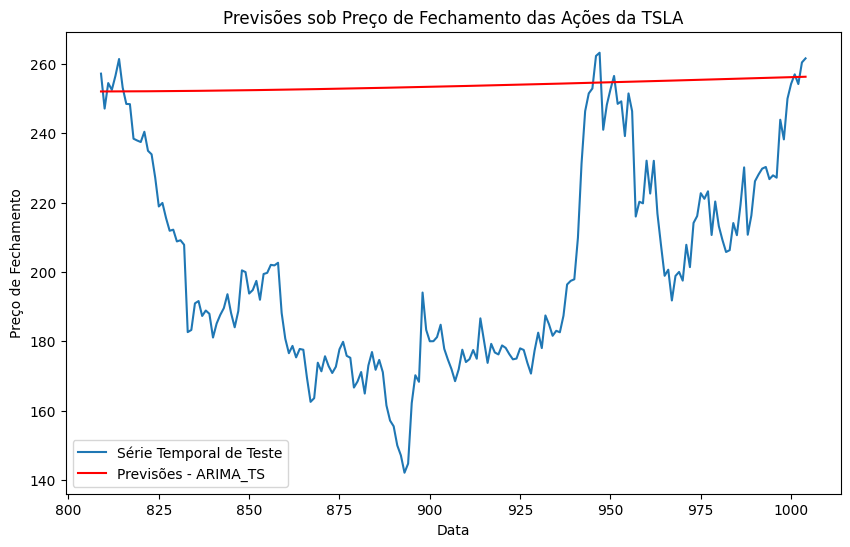

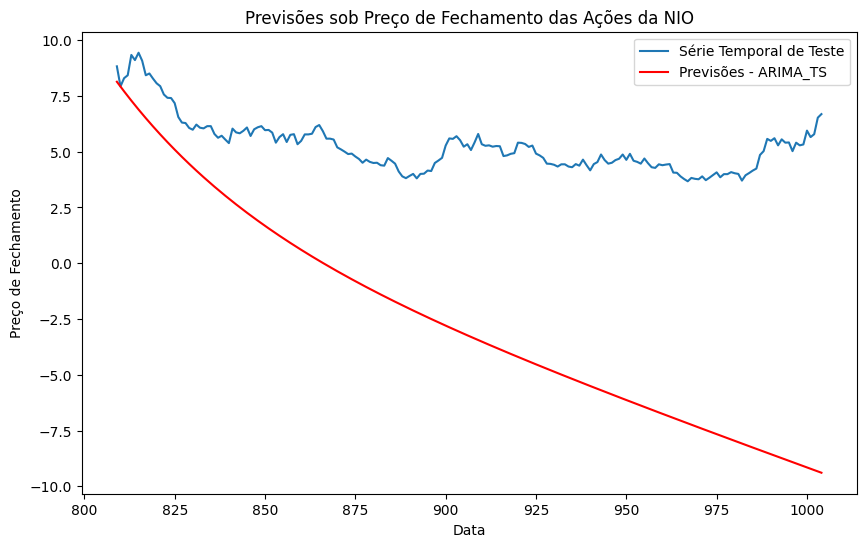

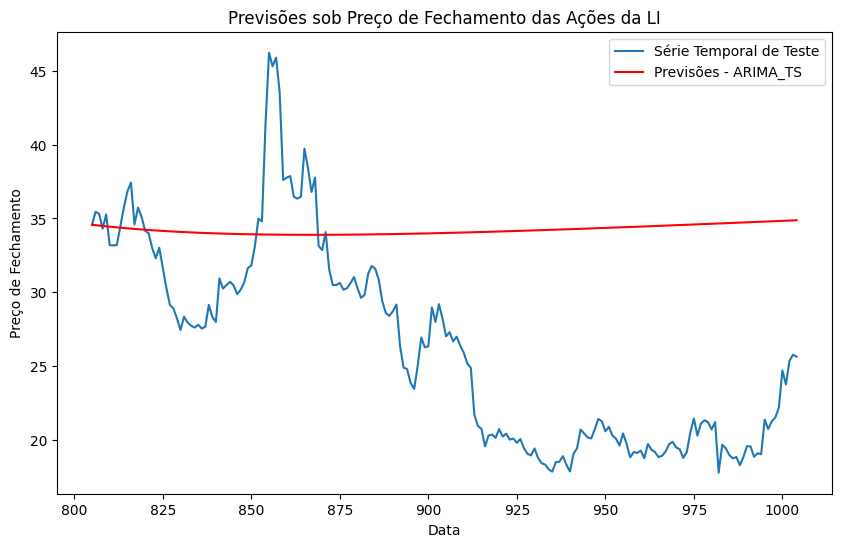

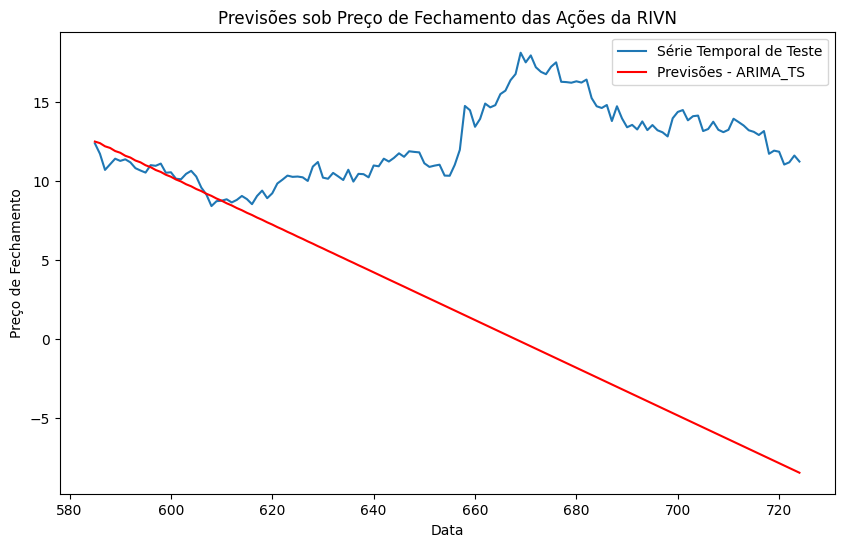

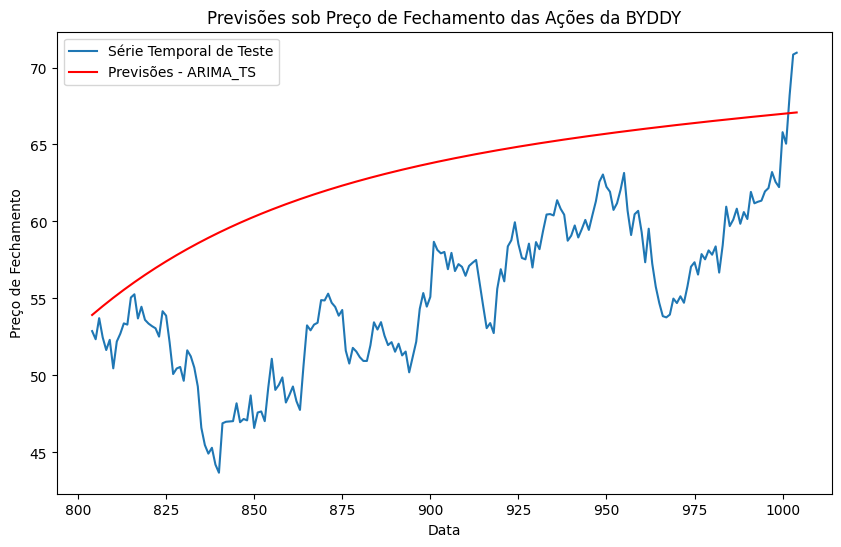

In [ ]:
for name in tickers:
    plt.figure(figsize=(10, 6))
    plt.plot(X_test[name].index, y_test[name], label='Série Temporal de Teste')
    plt.plot(X_test[name].index, previsoes_ts_ARIMA[name], label='Previsões - ARIMA_TS', color='red')
    plt.title(f'Previsões sob Preço de Fechamento das Ações da {name}')
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento')
    plt.legend()
    plt.show()

#### 4.1.2.3 DESEMPENHOS PRELIMINARES

In [ ]:
import auxiliar as ax

In [ ]:
metricas_rw_ARIMA = {}
for name in tickers:
    metricas_rw_ARIMA[name] = ax.calcular_metricas_regressao(y_test[name], previsoes_rw_ARIMA[name])

metricas_ts_ARIMA = {}
for name in tickers:
    metricas_ts_ARIMA[name] = ax.calcular_metricas_regressao(y_test[name], previsoes_ts_ARIMA[name])

In [ ]:

metricas_table_rw_ARIMA = pd.DataFrame(get_table_metrics(tickers, True, metricas_rw_ARIMA, tempos_train_rw_ARIMA, tempos_predict_rw_ARIMA))
metricas_table_ts_ARIMA = pd.DataFrame(get_table_metrics(tickers, False, metricas_ts_ARIMA, tempos_train_ts_ARIMA, tempos_predict_ts_ARIMA))


metricas_table_ARIMA = pd.concat([metricas_table_rw_ARIMA, metricas_table_ts_ARIMA], axis=0, ignore_index=True)
metricas_table_ARIMA = metricas_table_ARIMA.sort_values(by=['TS']).reset_index(drop=True)
metricas_table_ARIMA


,TS,rw,MSE,MAE,MAPE,RMSE,R^2,U de THEIL,ARV,WPOCID,Tempo Fit (s),Tempo Predict (s)
0,BYDDY,True,1.443329,0.940620,0.017102,1.201386,0.943019,1.004245,0.056981,0.575000,2.091692,0.015530
1,BYDDY,False,72.646812,7.780955,0.146115,8.523310,-1.867997,50.661724,2.867997,0.475000,11.271129,0.012011
2,LI,True,1.561311,0.808094,0.029814,1.249524,0.965853,1.001352,0.034147,0.507538,4.274721,0.015999
3,LI,False,110.953024,8.969794,0.412721,10.533424,-1.426634,71.160672,2.426634,0.527638,12.012501,0.012002
4,NIO,True,0.066469,0.192751,0.036036,0.257816,0.953553,1.061867,0.046447,0.482051,2.380529,0.014003
5,NIO,False,75.697595,7.786324,1.629381,8.700436,-51.896155,1238.935505,52.896155,0.446154,17.811681,0.008988
6,RIVN,True,0.342853,0.437801,0.035951,0.585536,0.940357,1.141321,0.059643,0.561151,2.154348,0.012018
7,RIVN,False,166.622658,10.394513,0.777349,12.908240,-27.985765,556.950074,28.985765,0.474820,7.356567,0.011989
8,TSLA,True,53.236386,5.312283,0.026314,7.296327,0.939915,0.999897,0.060085,0.543590,3.091208,0.018999
9,TSLA,False,3561.900282,52.494938,0.285975,59.681658,-3.020091,67.065197,4.020091,0.487179,31.627001,0.016019


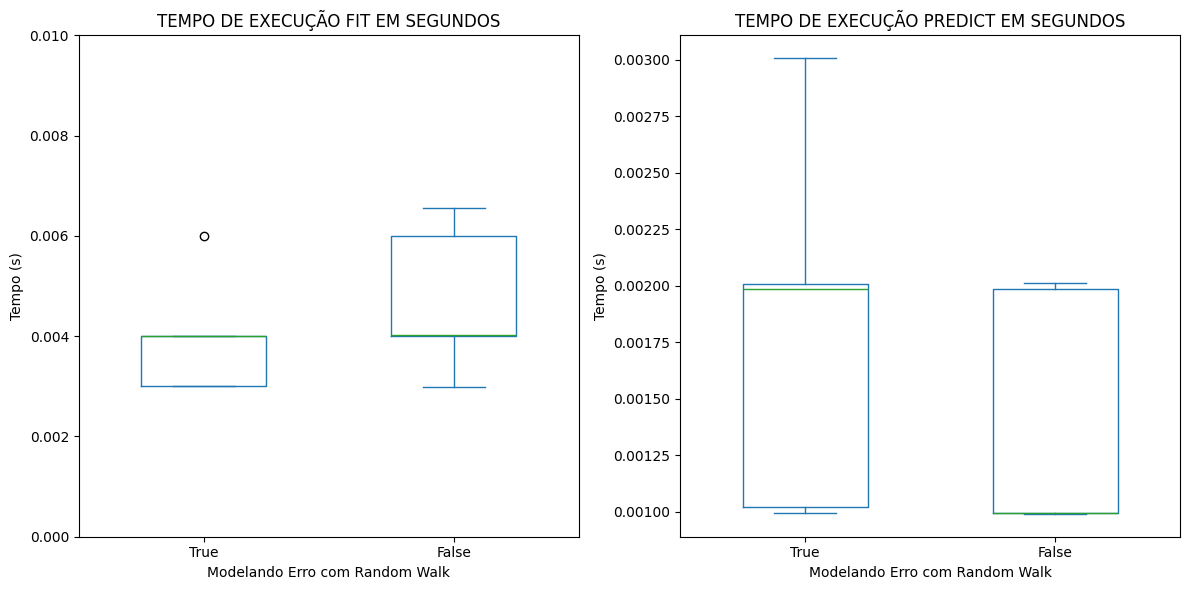

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))


metricas_table_LR[metricas_table_ARIMA['rw'] == True]['Tempo Fit (s)'].plot.box(ax=ax[0], positions=[0], widths=0.5)
metricas_table_LR[metricas_table_ARIMA['rw'] == False]['Tempo Fit (s)'].plot.box(ax=ax[0], positions=[1], widths=0.5)
ax[0].set_title("TEMPO DE EXECUÇÃO FIT EM SEGUNDOS")
ax[0].set_ylabel("Tempo (s)")
ax[0].set_xlabel("Modelando Erro com Random Walk")
ax[0].set_xticklabels(['True', 'False'])
ax[0].set_ylim(0, 0.010) 


metricas_table_LR[metricas_table_ARIMA['rw'] == True]['Tempo Predict (s)'].plot.box(ax=ax[1], positions=[0], widths=0.5)
metricas_table_LR[metricas_table_ARIMA['rw'] == False]['Tempo Predict (s)'].plot.box(ax=ax[1], positions=[1], widths=0.5)
ax[1].set_title("TEMPO DE EXECUÇÃO PREDICT EM SEGUNDOS")
ax[1].set_ylabel("Tempo (s)")
ax[1].set_xlabel("Modelando Erro com Random Walk")
ax[1].set_xticklabels(['True', 'False'])

plt.tight_layout()
plt.suptitle("")
plt.show()

### 4.1.3 Modelo de Árvore de Decisão Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from skopt import gp_minimize

In [ ]:
space = [
    Integer(1, 50, name='max_depth'),                # profundidade máxima da árvore
    Integer(2, 50, name='min_samples_split'),         # mínimo de amostras para dividir um nó
    Integer(1, 50, name='min_samples_leaf'),           # mínimo de amostras em um nó folha            
    Real(0.1, 1.0, name='max_features'),                # fração de características a serem consideradas
]

In [ ]:
def objective_rw(params):
    max_depth, min_samples_split, min_samples_leaf, max_features  = params
    model = DecisionTreeRegressor(
            max_depth=int(max_depth),
            min_samples_split=int(min_samples_split),
            min_samples_leaf=int(min_samples_leaf),
            max_features=max_features
    )
    model.fit(X_E_rw_train, y)

    # Fazer previsões
    y_pred = model.predict(X)
    return mean_squared_error(y, y_pred)

In [ ]:
gp_minimize(objective1, space, n_calls=50, random_state=42)

NameError: name 'objective1' is not defined

#### 4.1.3.1 MODELAGEM E PREVISÃO DO ERRO DO RANDOM WALK

#### 4.1.3.2 MODELAGEM E PREVISÃO DA SÉRIE TEMPORAL ORIGINAL

#### 4.1.3.3 DESEMPENHOS PRELIMINARES

# 5 - ANÁLISE DE DESEMPENHO GERAL

## 5.1 - DESEMPENHO ESTATÍSTICO

## 5.2 - DESEMPENHO COMPUTACIONAL